# 1. Pytorch进行神经传递

In [1]:
# 不同风格的交互

In [2]:
from __future__ import print_function  # 用于在python2中启用python3中的print函数；确保新版本能在旧版本中使用

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

In [7]:
loader = transforms.Compose([
    transforms.Resize(imsize), # scale imported Image
    transforms.ToTensor(), # transform it into a torch tensor
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)  # 将图像张量 image 的形状从 (C, H, W) 变成 (1, C, H, W)，
    return image.to(device, torch.float)

style_img = image_loader(r"/home/zya/zya/AI/learning/Pytorch_from_begining/picasso.jpg")
content_img = image_loader(r"/home/zya/zya/AI/learning/Pytorch_from_begining/dancing.jpg")

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

In [8]:
# 创建显示图像的功能，将图像的副本转换为PIL格式，然后用plt.imshow显示副本
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()  # 打开交互模式, Matplotlib会在绘图命令后立即更新图像窗口 plt.ioff()关闭交互模式；

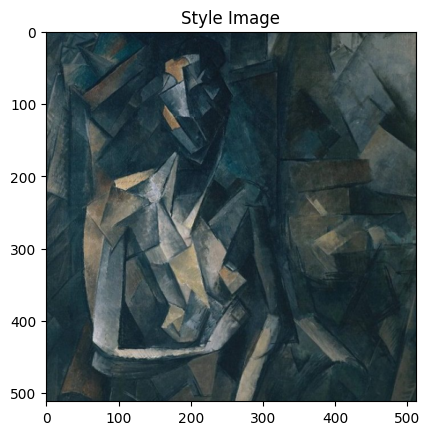

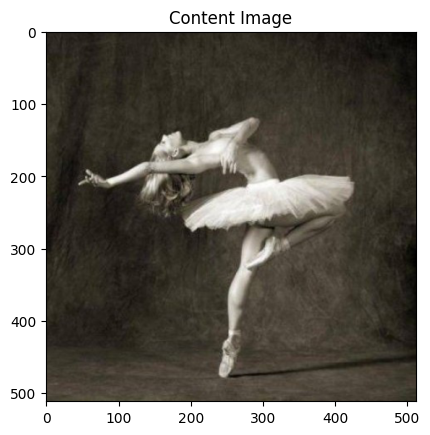

In [9]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(style_img, title='Style Image')
plt.figure()
imshow(content_img, title='Content Image')

### 内容损失

In [13]:
# 该功能获取网络处理输入中层的特征图；并返回图像和内容图像之间的加权内容距离；距离是两组特征图之间的均方误差，可以使用nn.MSELoss计算；
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### 风格损失

In [14]:
# 样式丢失模块的实现类似于内容丢失模块。在网络中它将充当透明层，计算该层的样式损失。
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)
    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
    G = torch.mm(features, features.t())  # compute the gram product
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [15]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# 导入模型

In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()


/home/zya/.conda/envs/ISV_training/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zya/.conda/envs/ISV_training/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/zya/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    
    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [20]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']  # 深层是内容，浅层是纹理/风格；
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img, content_layers=content_layers_default, style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []
    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        model.add_module(name, layer)
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]
    return model, style_losses, content_losses

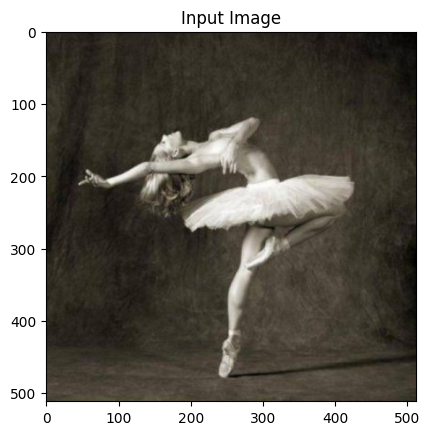

In [16]:
input_img = content_img.clone()
## if you want to use white noise instead uncomment the below line:
## input_img = torch.randn(content_img.data.size(), device=device)
## add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

### 梯度下降

In [17]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])  # 拟牛顿优化方法；L-BFGS； optim.LBFGS需要的是一个闭包；
    return optimizer

In [22]:
def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps=500, style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
            return style_score + content_score
        optimizer.step(closure)
    # a last correction...
    input_img.data.clamp_(0, 1)
    return input_img

Building the style transfer model..
Optimizing..


/tmp/ipykernel_14172/420557760.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_14172/420557760.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 0.218949 Content Loss: 2.978717

run [100]:
Style Loss : 0.210212 Content Loss: 2.886145



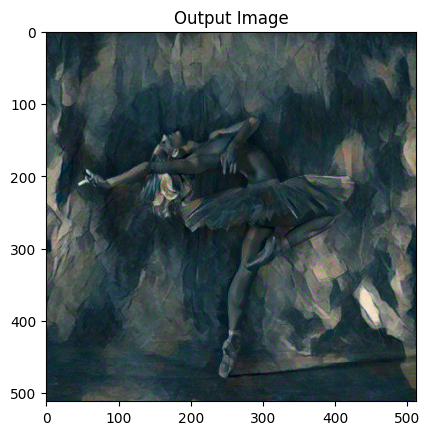

In [27]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, num_steps=100)
plt.figure()
imshow(output, title='Output Image')
## sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

风格迁移（Style Transfer）的原理是使用深度学习模型（通常是卷积神经网络，CNN）将一张图像的风格特征（如笔触、颜色和纹理等）应用到另一张图像上，同时保持目标图像的内容特征。这个过程通过优化算法使一张“内容图像”逐渐具有另一张“风格图像”的视觉风格，同时尽可能保留其原始内容。
风格迁移的核心原理

风格迁移的原理主要基于以下几个关键点：

    深度卷积神经网络（CNN）:
        风格迁移利用了预训练的卷积神经网络（如 VGG 网络），这些网络已经在大型图像数据集（如 ImageNet）上训练过，可以提取图像的内容和风格特征。
        CNN 的不同层提取不同层次的特征：浅层特征通常包含细粒度的纹理、边缘等信息，而深层特征包含较抽象的语义信息（例如对象的整体形状）。

    内容特征和风格特征的分离:
        内容特征：内容图像的深层特征表示，即保留图像的主要形状、结构等信息。内容损失通过计算目标图像和内容图像在特定深度层上的特征图的差异来衡量图像内容的相似性。
        风格特征：风格图像的浅层特征表示，包括颜色分布、纹理等。风格损失通过计算目标图像和风格图像在不同卷积层上的“Gram矩阵”之间的差异来衡量图像风格的相似性。

    Gram矩阵（Gram Matrix）:
        Gram矩阵是图像风格特征的重要表示方法。它是图像特征图的协方差矩阵，能够捕获图像中的风格信息（如纹理和颜色分布）。
        对于一个给定的卷积层，计算它的特征映射矩阵 F，Gram矩阵 G 定义为 G = F * F^T，其中 F 是该层的特征图向量化后的结果。Gram矩阵的每个元素表示该层特征映射之间的内积，反映了不同特征映射之间的相似性和相关性。

    损失函数的定义:

        内容损失（Content Loss）: 内容损失用于衡量生成图像和内容图像在深度卷积网络的某些层上的特征表示的差异。通常使用均方误差（MSE）来计算生成图像和内容图像之间的内容特征差距：
        Lcontent(p,x,l)=12∑(Fxl−Fpl)2
        Lcontent​(p,x,l)=21​∑(Fxl​−Fpl​)2

        其中，FxlFxl​ 和 FplFpl​ 分别表示生成图像和内容图像在层 ll 上的特征映射。

        风格损失（Style Loss）: 风格损失用于衡量生成图像和风格图像在深度卷积网络的多层上特征图之间的统计差异（Gram矩阵的差异）：
        Lstyle(a,x)=∑lwlEl
        Lstyle​(a,x)=l∑​wl​El​

        其中，El=14Nl2Ml2∑(Gxl−Gal)2El​=4Nl2​Ml2​1​∑(Gxl​−Gal​)2 表示生成图像和风格图像在第 ll 层的Gram矩阵之间的差异，NlNl​ 是层 ll 的特征映射数量，MlMl​ 是该层每个特征映射的大小。

    优化过程:
        使用优化算法（如 L-BFGS 或 Adam）调整输入图像，使其总损失（风格损失和内容损失的加权和）最小化：
        Ltotal=αLcontent+βLstyle
        Ltotal​=αLcontent​+βLstyle​ 其中，αα 和 ββ 是权重因子，用于平衡内容和风格在总损失中的影响。

    输入图像更新:
        在每次迭代中，通过反向传播计算损失函数的梯度，并使用优化算法更新输入图像的像素值，使其逐渐接近目标风格，同时保留内容图像的结构特征。

风格迁移的流程

    预处理图像：将内容图像和风格图像输入到预训练的卷积神经网络中，提取其内容特征和风格特征。
    定义损失函数：根据提取的内容和风格特征，定义损失函数来衡量生成图像与目标内容图像、目标风格图像的相似度。
    初始化输入图像：通常使用内容图像或随机噪声作为初始输入图像。
    优化输入图像：使用优化算法不断调整输入图像，使其最小化总损失函数。
    输出结果图像：最终生成一幅新的图像，既保留了内容图像的基本结构，又具有风格图像的艺术风格。

风格迁移的应用

    艺术生成：将一幅图像转换为另一种艺术风格，如将照片转换为梵高或毕加索风格的画作。
    图像滤镜：应用于社交媒体上的各种图像滤镜。
    数据增强：在计算机视觉任务中，风格迁移可以用来生成具有多种风格的图像数据，以增强模型的泛化能力。

总结

风格迁移利用了卷积神经网络提取图像的内容特征和风格特征，通过优化算法调整输入图像的像素值，使其逐渐符合目标图像的风格特征，同时保持原始图像的内容特征。其核心思想在于将深度学习和优化算法结合，生成具有特定风格效果的图像。